In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
cd ../src

/home/theo/mva/dlir/src


In [4]:
import torch
torch.cuda.is_available()

True

# Imports

In [5]:
from utils import *
from params import *

In [6]:
from metric import *

In [7]:
from training import *
from dcgan import *
from data import *

In [8]:
import time
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from PIL import Image

# Initialization

In [9]:
begin = time.time()
seed_everything(seed)

## Load Data

In [10]:
print('Number of dog images :', len(IMAGES))

Number of dog images : 20579


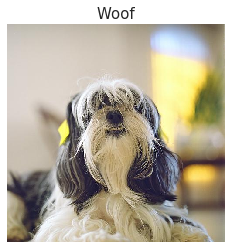

In [11]:
img = Image.open(IMAGES[0])
plt.imshow(img)
plt.title('Woof', size=15)
plt.axis(False)
plt.show()

## Seeding

# Dataset

In [12]:
%%time
dataset = DogDataset(DATA_PATH, base_transforms, additional_transforms)

CPU times: user 25 s, sys: 0 ns, total: 25 s
Wall time: 25 s


In [13]:
nb_classes = len(dataset.classes)
print(f'Number of dog breeds : {nb_classes}')

Number of dog breeds : 120


In [14]:
nb_dogs = len(dataset)
print(f'Number of dog: {nb_dogs}')

Number of dog: 22125


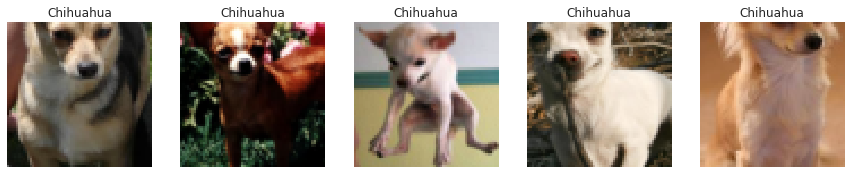

In [15]:
n = 5
plt.figure(figsize=(15, 3))
for idx, i in enumerate(range(n)):#enumerate(np.random.choice(len(dataset), n)):
    plt.subplot(1, n, idx + 1)
    img, breed = dataset[i]
    img = img.numpy().transpose(1, 2, 0)
    img = (img - img.min()) / (img.max() - img.min())
    plt.imshow(img)
    plt.axis(False)
    
    plt.title(dataset.classes[breed])
plt.show()

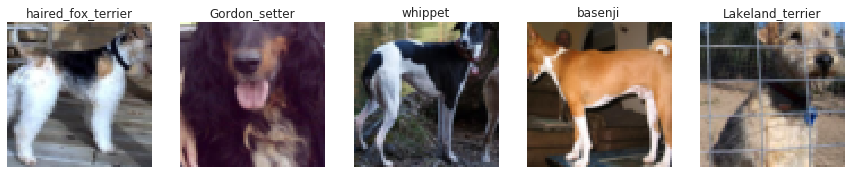

In [16]:
n = 5
plt.figure(figsize=(15, 3))
for idx, i in enumerate(np.random.choice(len(dataset), n)):
    plt.subplot(1, n, idx + 1)
    img, breed = dataset[i]
    img = img.numpy().transpose(1, 2, 0)
    img = (img - img.min()) / (img.max() - img.min())
    plt.imshow(img)
    plt.axis(False)
    
    plt.title(dataset.classes[breed])
plt.show()

## Fit

In [17]:
import torch
import torch.nn as nn
import torch.utils.data
import torch.nn.functional as F
from torch.nn import Parameter
from torch.autograd import Variable
from torch.optim.lr_scheduler import *

In [18]:
def fit(discriminator, generator, dataset, latent_dim=128, epochs=100, batch_size=32, 
        lr_d=1e-3, lr_g=1e-3, scheduler=False, label_smoothing=False, smooth_label=1,
        class_loss_weight=0., use_ft_matching=False, conditional=False,
        seed=2019, verbose=1, verbose_mifid=100):
    
    seed_everything(seed)
    fixed_noise = torch.FloatTensor(5, latent_dim, 1, 1).normal_(0, 1).cuda()
    fixed_classes = torch.from_numpy(np.array([119, 9, 27, 36, 64])).long().cuda()
    infos = {"discriminator_loss": [], "generator_loss": [], 'generator_lr': [], 'discriminator_lr': [], "scores": []}
    
    optimizer_d = torch.optim.Adam(discriminator.parameters(), lr=lr_d, betas=(0.5, 0.999))
    optimizer_g = torch.optim.Adam(generator.parameters(), lr=lr_g, betas=(0.5, 0.999))
    
    scheduler_d = CosineAnnealingLR(optimizer_d, T_max=epochs, eta_min=1e-5) #lr_d/100
    scheduler_g = CosineAnnealingLR(optimizer_g, T_max=epochs, eta_min=1e-5) #lr_g/100
    
    loss_fn = nn.BCEWithLogitsLoss(reduction='sum')
    loss_classes_fn = nn.CrossEntropyLoss(reduction='sum')
    loss_ft_matching = nn.MSELoss(reduction='sum')
    
    real_label = smooth_label if label_smoothing else 1.
    fake_label = 0.
    
    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, num_workers=4, shuffle=True)

    for epoch in range(epochs):
        start_time = time.time()  
        d_loss = 0
        g_loss = 0
        
        if scheduler:
            scheduler_d.step()
            scheduler_g.step()
            lr_d = np.mean([param_group['lr'] for param_group in optimizer_d.param_groups])
            lr_g = np.mean([param_group['lr'] for param_group in optimizer_g.param_groups])
            
        for x, y in loader:
            t0 = time.time()

            ########   Update discriminator ########

            discriminator.zero_grad()
            batch_size = x.size(0)

            # Real images

            labels = torch.full((batch_size, 1), real_label).cuda()

            output, out_classes, _ = discriminator(x.cuda(), y.cuda())

            loss_real = loss_fn(output, labels)
            if class_loss_weight:
                loss_real += class_loss_weight * loss_classes_fn(out_classes, y.cuda())
            loss_real.backward()

            # Fake images

            noise = torch.cuda.FloatTensor(batch_size, latent_dim, 1, 1).normal_(0, 1)
            fake_classes = torch.from_numpy(np.random.randint(0, nb_classes, size=batch_size)).long().cuda()
            fake = generator(noise, fake_classes)

            labels.fill_(fake_label)
            output, out_classes, _ = discriminator(fake.detach(), fake_classes)

            loss_fake = loss_fn(output, labels)
            if class_loss_weight:
                loss_fake += class_loss_weight * loss_classes_fn(out_classes, fake_classes)
                
            loss_fake.backward()
            optimizer_d.step()
            
            d_loss += (loss_real + loss_fake).item() / len(dataset)
            
            ########   Update Generator   ########
            
            generator.zero_grad()
            labels.fill_(real_label)
            
            noise = torch.cuda.FloatTensor(batch_size, latent_dim, 1, 1).normal_(0, 1)
            fake_classes = torch.from_numpy(np.random.randint(0, nb_classes, size=batch_size)).long().cuda()
            
            output_fake, out_classes, features_fake = discriminator(fake, fake_classes)
            
            if use_ft_matching:
                _, _, features_real = discriminator(x.cuda(), y.cuda())
                loss_g = loss_ft_matching(torch.mean(features_real, 0), torch.mean(features_fake, 0))
            else:
                loss_g = loss_fn(output_fake, labels)
                
            if class_loss_weight:
                loss_g += class_loss_weight * loss_classes_fn(out_classes, fake_classes)
                
            loss_g.backward()
            
            g_loss += loss_g.item() / len(dataset)
            optimizer_g.step()   

        elapsed_time = time.time() - start_time
        
        infos['discriminator_loss'].append(d_loss)
        infos['generator_loss'].append(g_loss)
        infos['generator_lr'].append(lr_g)
        infos['discriminator_lr'].append(lr_d)
        
        if (epoch + 1) % verbose == 0:
            elapsed_time = elapsed_time * verbose
            print(f'Epoch {epoch+1}/{epochs}     lr_g={lr_g:.1e}     lr_d={lr_d:.1e}', end='     ')
            print(f'disc_loss={d_loss:.3f}     gen_loss={g_loss:.3f}     t={elapsed_time:.0f}s')
            if (epoch + 1) % verbose_mifid == 0 and epoch > 150:
                score = tmp_eval(generator, n_images=10000, latent_dim=latent_dim, nb_classes=nb_classes)
                seed_everything(seed + epoch)
                infos["scores"].append(score)
                print(f'\n -> FID at epoch {epoch+1} is {score:.3f} \n')
            elif (epoch + 1) % 10 == 0:
                generate(generator, noise=fixed_noise, classes=fixed_classes, 
                         n=5, n_plot=5, latent_dim=latent_dim, show_title=conditional)
                
    return infos

# Training

In [19]:
seed_everything(seed)

## Parameters

### Architecture

In [20]:
n_gen = 128
n_dis = 128

latent_dim = 100
use_bn = True

### Conditioning

In [21]:
conditional = False

auxiliary_clf = True
class_loss_weight = 1 if auxiliary_clf else 0

one_hot = True

In [22]:
nb_ft = n_dis
embed_dim = nb_ft

### Training

In [23]:
epochs = 200
batch_size = 64

lr_g = 1e-3 
lr_d = 5e-4

In [24]:
scheduler = True

if scheduler:
    lr_g *= 2
    lr_d *= 2

### Feature matching

In [25]:
use_ft_matching = False

### Label smoothing

In [26]:
label_smoothing = False
smooth_label = 0.5 if label_smoothing else 0

## Create models

In [27]:
discriminator = DCGanDiscriminator(
    n=n_gen, 
    nb_ft=nb_ft,
    nb_classes=nb_classes, 
    embedding_dim=embed_dim, 
    conditional=conditional,
    auxiliary_clf=auxiliary_clf,
    use_bn=use_bn,
).cuda()

generator = DCGanGenerator(
    n=n_dis, 
    latent_dim=latent_dim, 
    nb_classes=nb_classes, 
    embedding_dim=embed_dim,
    conditional=conditional or auxiliary_clf,
    one_hot=one_hot,
    use_bn=use_bn,
).cuda()

discriminator.apply(weights_init)
generator.apply(weights_init)

print('Build DCGAN.')

Build DCGAN.


### Conditional DCGAN with projective discriminator

In [28]:
use_projected_dis = False

In [29]:
if use_projected_dis:
    discriminator = CDCGanDiscriminator(
        n=n_gen, 
        nb_ft=n_gen,
        nb_classes=nb_classes, 
        use_bn=use_bn,
    ).cuda()

    generator = DCGanGenerator(
        n=n_dis, 
        latent_dim=latent_dim, 
        nb_classes=nb_classes, 
        conditional=True,
        one_hot=True,
        use_bn=use_bn,
    ).cuda()

    discriminator.apply(weights_init)
    generator.apply(weights_init)

    print('Build cDCGAN.')

## Fit

In [ ]:
infos = fit(discriminator, generator, dataset, latent_dim=latent_dim, epochs=epochs, 
            batch_size=batch_size, lr_g=lr_g, lr_d=lr_d, scheduler=scheduler,
            label_smoothing=label_smoothing, smooth_label=smooth_label, 
            class_loss_weight=class_loss_weight, 
            use_ft_matching=use_ft_matching, 
            conditional=generator.conditional)

Epoch 1/200     lr_g=2.0e-03     lr_d=1.0e-03     disc_loss=12.416     gen_loss=9.027     t=44s
Epoch 2/200     lr_g=2.0e-03     lr_d=1.0e-03     disc_loss=10.793     gen_loss=7.009     t=44s
Epoch 3/200     lr_g=2.0e-03     lr_d=1.0e-03     disc_loss=10.518     gen_loss=7.010     t=44s
Epoch 4/200     lr_g=2.0e-03     lr_d=1.0e-03     disc_loss=10.359     gen_loss=6.981     t=44s
Epoch 5/200     lr_g=2.0e-03     lr_d=1.0e-03     disc_loss=10.326     gen_loss=6.609     t=44s
Epoch 6/200     lr_g=2.0e-03     lr_d=1.0e-03     disc_loss=10.229     gen_loss=6.751     t=44s
Epoch 7/200     lr_g=2.0e-03     lr_d=1.0e-03     disc_loss=10.136     gen_loss=6.933     t=45s


## Results

### FID

In [112]:
try:
    score = infos['scores'][-1]
except:
    score = tmp_eval(generator, n_images=10000, latent_dim=latent_dim)

print(f'\n -> FID {score:.3f} \n')


 -> FID 62.795 



### Save Models

In [113]:
# save_model_weights(generator, f'cond_gen_{str(datetime.date.today())}.pth')
# save_model_weights(discriminator, f'cond_dis_{56.5str(datetime.date.today())}.pth')

### Loss Curves

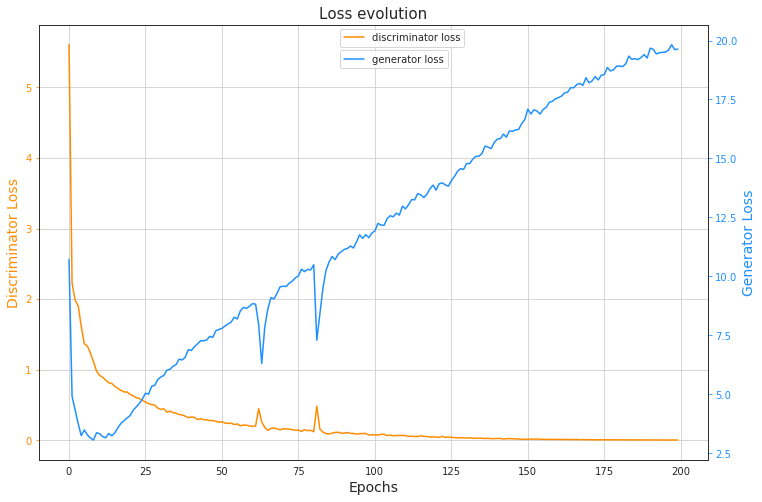

In [114]:
plot_losses(infos)

### Generated Doggos

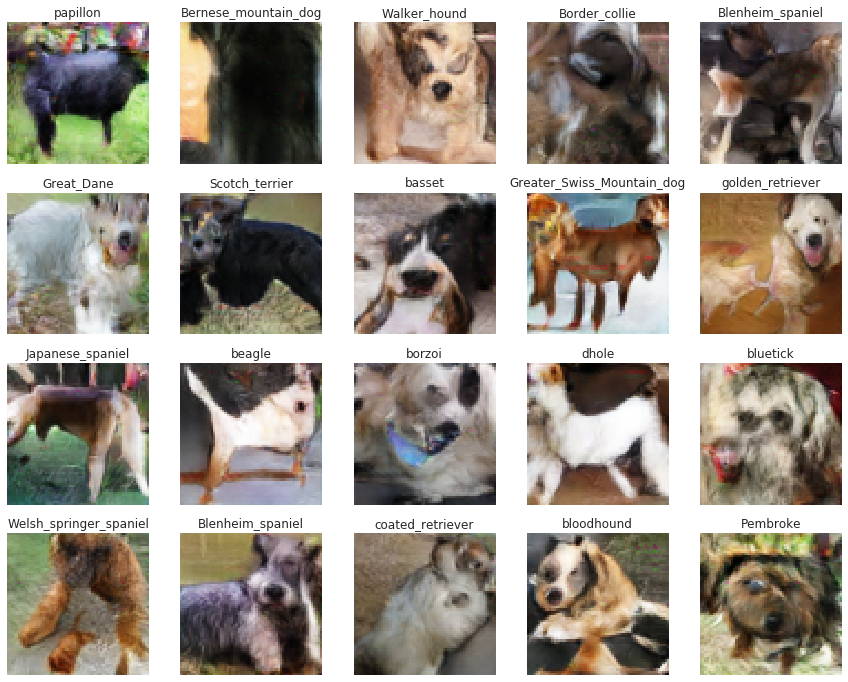

In [117]:
_ = generate(generator, n=20, n_plot=20, latent_dim=latent_dim, show_title=generator.conditional)

### Latent Walk

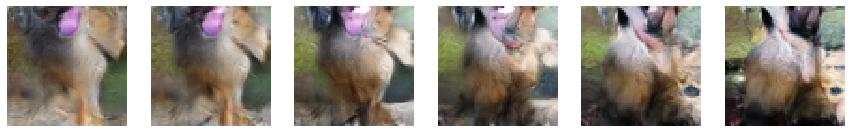

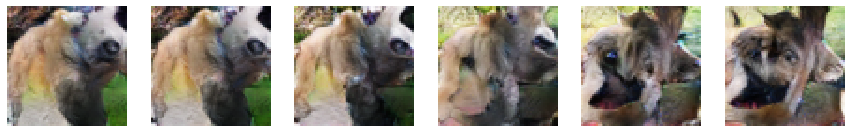

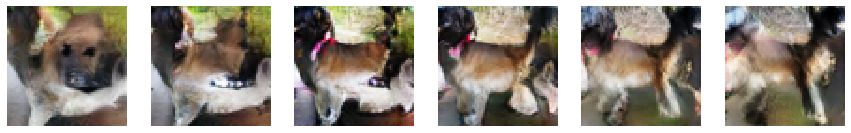

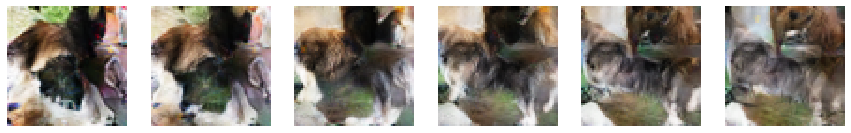

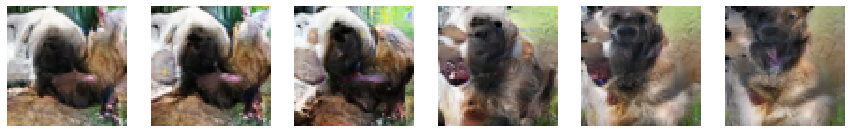

In [40]:
for i in range(5):
    latent_walk(generator, n=5, latent_dim=latent_dim)

In [41]:
print(f"Done in {(time.time() - begin)/60:.1f} minutes")

Done in 193.1 minutes
